COVID Global Forecast: SIR model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
# Load dataset
train = pd.read_csv(r"C:\Users\Administrator\Desktop\Vinuwara_IRP_A.I.D.S_2024\Code\Dataset\Dataset.csv")

# Filter data for Sri Lanka
country_df = train[train['Country'] == 'Sri Lanka'].copy()
country_df['Date_reported'] = pd.to_datetime(country_df['Date_reported'])
country_df = country_df.sort_values('Date_reported')

In [174]:
display(country_df.head())

,Date,Date_reported,Country,Susceptibility,New_cases,Total_Infected,New_deaths,Total_Deaths,Recovered
0,1,2020-01-04,Sri Lanka,23229470,0,0,0,0,0
1,2,2020-01-05,Sri Lanka,23229470,0,0,0,0,0
2,3,2020-01-06,Sri Lanka,23229470,0,0,0,0,0
3,4,2020-01-07,Sri Lanka,23229470,0,0,0,0,0
4,5,2020-01-08,Sri Lanka,23229470,0,0,0,0,0


In [175]:
# Use only the first 6 months (approximately 180 days)
six_months_data = country_df[:180]  # Adjust the number of days as needed

# Use Total_Infected as target (ydata)
ydata = six_months_data['Total_Infected'].values
xdata = np.arange(1, len(ydata) + 1)  # Day count starting from 1

In [176]:
# SIR Model Functions
def fa(N, a, b, beta):
    return -beta * a * b

def fb(N, a, b, beta, gamma):
    return beta * a * b - gamma * b

def fc(N, b, gamma):
    return gamma * b

def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta) * hs
    b1 = fb(N, a, b, beta, gamma) * hs
    c1 = fc(N, b, gamma) * hs
    ak = a + a1 * 0.5
    bk = b + b1 * 0.5
    ck = c + c1 * 0.5
    a2 = fa(N, ak, bk, beta) * hs
    b2 = fb(N, ak, bk, beta, gamma) * hs
    c2 = fc(N, bk, gamma) * hs
    ak = a + a2 * 0.5
    bk = b + b2 * 0.5
    ck = c + c2 * 0.5
    a3 = fa(N, ak, bk, beta) * hs
    b3 = fb(N, ak, bk, beta, gamma) * hs
    c3 = fc(N, bk, gamma) * hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta) * hs
    b4 = fb(N, ak, bk, beta, gamma) * hs
    c4 = fc(N, bk, gamma) * hs
    a += (a1 + 2 * (a2 + a3) + a4) / 6
    b += (b1 + 2 * (b2 + b3) + b4) / 6
    c += (c1 + 2 * (c2 + c3) + c4) / 6
    return a, b, c

def SIR(N, b0, beta, gamma, hs, days):
    a = float(N - 1) / N - b0
    b = float(1) / N + b0
    c = 0.

    sus, inf, rec = [], [], []
    for i in range(days):
        sus.append(a)
        inf.append(b * N)  # Convert to actual number of infected
        rec.append(c)
        a, b, c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

In [ ]:
# Model Parameters
N = 23229470  # Sri Lanka population
b0 = 1e-6  # Small initial infection to avoid division by zero
beta = 0.3
gamma = 0.1
hs = 0.1

In [178]:
# Forecast SIR model for past 6 months + 30 future days
forecast_days = len(ydata) + 30  
sus, inf, rec = SIR(N, b0, beta, gamma, hs, forecast_days)

# Prepare Dataframe
data = pd.DataFrame({
    'Days': np.arange(1, forecast_days + 1),
    'SIR_Infected': inf,
})

# Ensure no zeros in infected data
data['SIR_Infected'] = data['SIR_Infected'].apply(lambda x: max(x, 0.01))

# Append actual data (only for available days)
data['Actual_Infected'] = np.nan
data.loc[:len(ydata)-1, 'Actual_Infected'] = ydata

# Replace any zeros in actual data (to avoid division by zero in MAPE)
data['Actual_Infected'] = data['Actual_Infected'].fillna(0).apply(lambda x: max(x, 0.01))

# Normalize data
scaler = StandardScaler()
# Use only non-NaN values for fitting the scaler
valid_data = data[['SIR_Infected', 'Actual_Infected']].dropna()
scaler.fit(valid_data)

# Transform all data (including NaNs)
data_scaled = np.copy(data[['SIR_Infected', 'Actual_Infected']].values)
for i in range(len(data_scaled)):
    if not np.isnan(data_scaled[i, 1]):  # If not NaN
        data_scaled[i] = scaler.transform([data_scaled[i]])[0]

# Prepare dataset for LSTM - handle NaN values
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        # Skip sequences with NaN values
        if not np.isnan(data[i:i+look_back+1]).any():
            X.append(data[i:(i + look_back), :])
            y.append(data[i + look_back, 1])  # Predict Actual_Infected
    return np.array(X), np.array(y)

d:\conda\envs\SIR_model\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\conda\envs\SIR_model\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\conda\envs\SIR_model\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\conda\envs\SIR_model\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\conda\envs\SIR_model\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\conda\envs\SIR_model\lib\site-package

In [179]:
look_back = 20  
X, y = create_dataset(data_scaled[:len(ydata)], look_back)

# Split into train and test sets (80% past data for training)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(64, input_shape=(look_back, 2), return_sequences=True, kernel_regularizer=l2(0.001)),  
    Dropout(0.3),
    LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001)),  
    Dropout(0.3),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# Train Model with more epochs and patience
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

d:\conda\envs\SIR_model\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                  │ (None, 20, 64)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,601 (115.63 KB)

 Trainable params: 29,601 (115.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.4098 - val_loss: 1.8362
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2402 - val_loss: 0.5988
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1084 - val_loss: 0.0964
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1023 - val_loss: 0.0787
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0875 - val_loss: 0.1907
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0839 - val_loss: 0.1591
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0849 - val_loss: 0.1351
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0757 - val_loss: 0.1183
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0713 - val_loss: 0.0669
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0661 - val_loss: 0.0682
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0673 - val_loss: 0.1893
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0612 - val_l

In [180]:
# Predict using LSTM
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Prepare data for inverse scaling
def inverse_transform_predictions(predictions, x_data, scaler):
    # Combine last feature of X data with predictions
    combined = np.concatenate((x_data[:, -1, 0].reshape(-1, 1), predictions), axis=1)
    # Inverse transform
    return scaler.inverse_transform(combined)[:, 1]

# Inverse transform predictions
y_train_true = inverse_transform_predictions(np.array([y_train]).T, X_train, scaler)
train_predict = inverse_transform_predictions(train_predict, X_train, scaler)
y_test_true = inverse_transform_predictions(np.array([y_test]).T, X_test, scaler)
test_predict = inverse_transform_predictions(test_predict, X_test, scaler)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [184]:
# Calculate metrics - safely handle division by zero for MAPE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Handle MAPE calculation safely
    y_true_safe = np.array(y_true).copy()
    # Replace zeros with a small value
    y_true_safe[y_true_safe == 0] = 0.01
    
    # Calculate MAPE
    mape = np.mean(np.abs((y_true_safe - y_pred) / y_true_safe)) * 100
    accuracy = 100 - mape
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'Accuracy': accuracy
    }

# Calculate metrics
test_metrics = calculate_metrics(y_test_true, test_predict)


print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")


Test Metrics:
RMSE: 67.3215
MAE: 51.4687
R2: 0.6408
MAPE: 2.8423
Accuracy: 97.1577


model shows a good overall performance with high accuracy and relatively low error metrics (like MAPE). The R² value suggests there's still room for improvement, but it is on the higher side for typical forecasting tasks. You might want to focus on reducing RMSE and MAE to improve prediction accuracy further.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

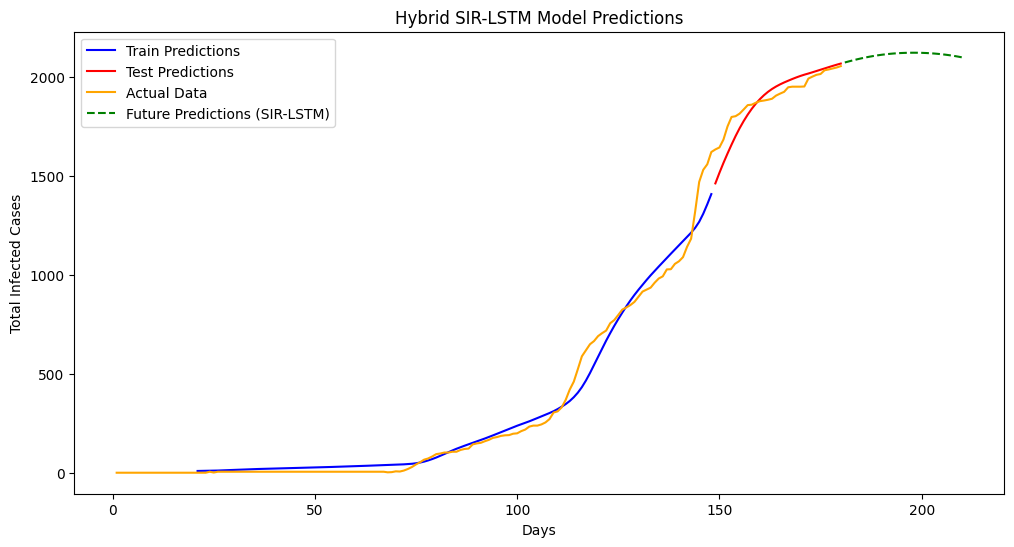

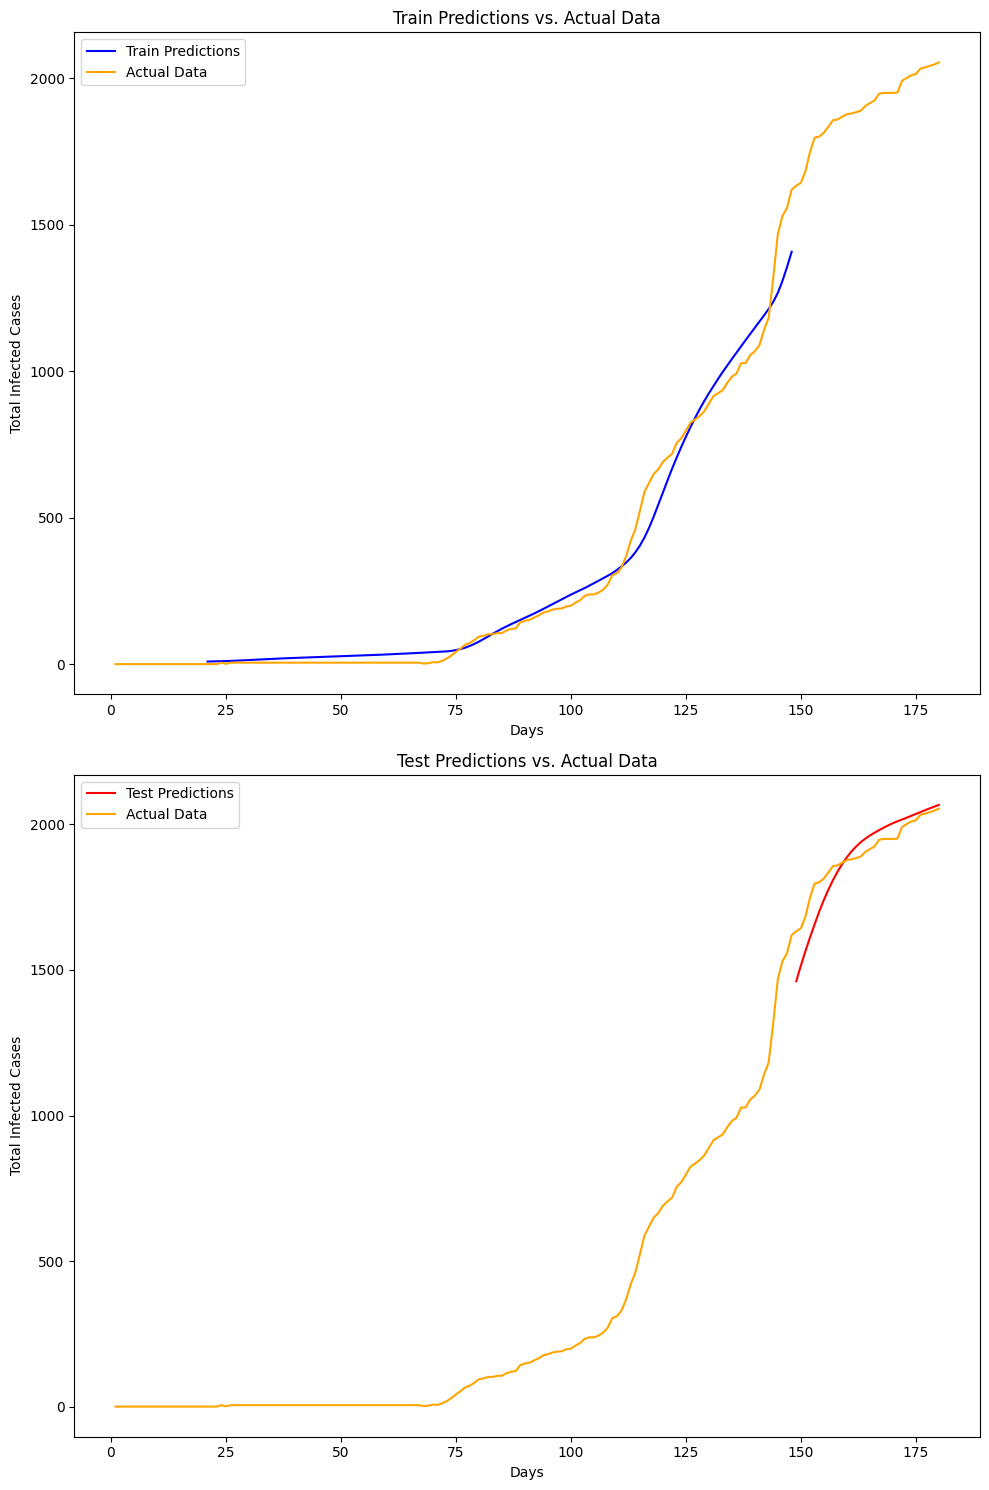

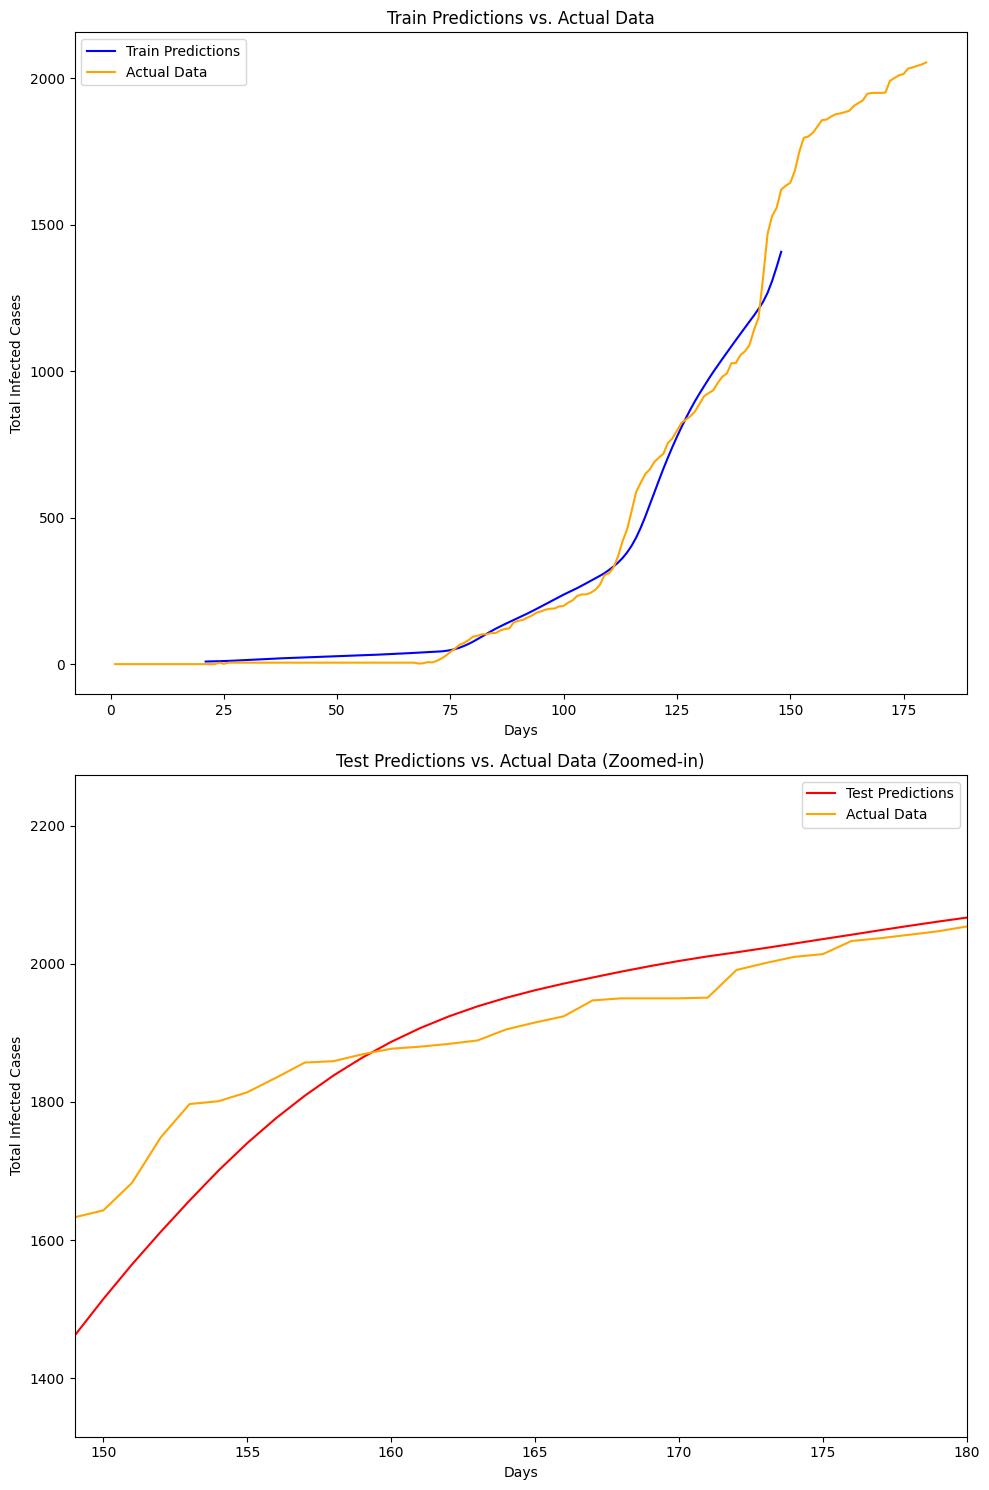

In [182]:
# Prepare for future prediction
# Create a sequence of the last look_back days with actual data
last_sequence = data_scaled[len(ydata)-look_back:len(ydata)].reshape(1, look_back, 2)

# Predict for the next 30 days
future_days = 30
future_predictions = []

for i in range(future_days):
    # Predict the next day
    next_pred = model.predict(last_sequence)
    
    # Create a new data point with SIR prediction and LSTM prediction
    new_point = np.array([data_scaled[len(ydata) + i, 0], next_pred[0][0]])
    
    # Append prediction
    future_predictions.append(next_pred[0][0])
    
    # Update the sequence by removing the first day and adding the new prediction
    new_sequence = np.copy(last_sequence[0, 1:])
    new_sequence = np.vstack([new_sequence, new_point])
    last_sequence = new_sequence.reshape(1, look_back, 2)

# Convert future predictions to original scale
future_points = np.zeros((len(future_predictions), 2))
future_points[:, 0] = data_scaled[len(ydata):len(ydata)+future_days, 0]
future_points[:, 1] = future_predictions
future_predictions_original = scaler.inverse_transform(future_points)[:, 1]

# Plot results
plt.figure(figsize=(12, 6))

# Train and test indices in the original dataset
train_indices = list(range(look_back, look_back + len(train_predict)))
test_indices = list(range(look_back + len(train_predict), look_back + len(train_predict) + len(test_predict)))

# Map indices to days
train_days = data['Days'][train_indices].values
test_days = data['Days'][test_indices].values
actual_days = data['Days'][:len(ydata)].values
future_days = data['Days'][len(ydata):len(ydata)+len(future_predictions)].values

# Plot
plt.plot(train_days, train_predict, label='Train Predictions', color='blue')
plt.plot(test_days, test_predict, label='Test Predictions', color='red')
plt.plot(actual_days, data['Actual_Infected'][:len(ydata)], label='Actual Data', color='orange')
plt.plot(future_days, future_predictions_original, label='Future Predictions (SIR-LSTM)', linestyle='dashed', color='green')

plt.title('Hybrid SIR-LSTM Model Predictions')
plt.xlabel('Days')
plt.ylabel('Total Infected Cases')
plt.legend()
plt.savefig('SIR_LSTM_Complete_Predictions.png', dpi=300)
plt.show()

# Create subplots for detailed analysis
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# Plot Train Predictions
axes[0].plot(train_days, train_predict, label='Train Predictions', color='blue')
axes[0].plot(actual_days, data['Actual_Infected'][:len(ydata)], label='Actual Data', color='orange')
axes[0].set_title('Train Predictions vs. Actual Data')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Total Infected Cases')
axes[0].legend()

# Plot Test Predictions
axes[1].plot(test_days, test_predict, label='Test Predictions', color='red')
axes[1].plot(actual_days, data['Actual_Infected'][:len(ydata)], label='Actual Data', color='orange')
axes[1].set_title('Test Predictions vs. Actual Data')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Total Infected Cases')
axes[1].legend()

# Adjust layout & save
plt.tight_layout()
plt.savefig('SIR_LSTM_Predictions.png', dpi=300)
plt.show()

# Create zoomed-in plot
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# Plot Train Predictions
axes[0].plot(train_days, train_predict, label='Train Predictions', color='blue')
axes[0].plot(actual_days, data['Actual_Infected'][:len(ydata)], label='Actual Data', color='orange')
axes[0].set_title('Train Predictions vs. Actual Data')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Total Infected Cases')
axes[0].legend()

# Plot Test Predictions (Zoomed-in)
axes[1].plot(test_days, test_predict, label='Test Predictions', color='red')
axes[1].plot(actual_days, data['Actual_Infected'][:len(ydata)], label='Actual Data', color='orange')

# Set zoom-in limits for better visualization
axes[1].set_xlim([min(test_days), max(test_days)])  # Zoom into test period
axes[1].set_ylim([min(test_predict) * 0.9, max(test_predict) * 1.1])  # Adjust y-axis range

axes[1].set_title('Test Predictions vs. Actual Data (Zoomed-in)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Total Infected Cases')
axes[1].legend()

# Adjust layout & save
plt.tight_layout()
plt.savefig('SIR_LSTM_Zoomed_Predictions.png', dpi=300)
plt.show()

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('SIR_LSTM_Training_Validation_Loss.png', dpi=300)
plt.show()